In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

In [2]:
im=cv2.imread("sample.jpeg")
im=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

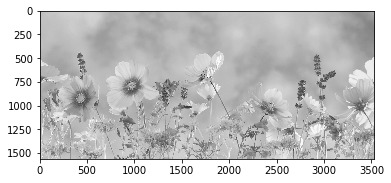

In [3]:
plt.imshow(im, cmap="gray")

In [4]:
im.shape

(1562, 3531)

In [5]:
# the convolution is implemented on the cpu and not optimizd
im=cv2.resize(im, (350, 150))

### Setting up weights for edge detection

I would like to scan the image for horizontal and vertical edges.
This is done by applying a 3x3 convolution with 2 filters.

In [6]:
# the image is just 2D
# the convolution expects a batch_size and a colors dimension, too
im=np.expand_dims(im, 0)
im=np.expand_dims(im, -1)

# dimensions of the image
batch_size, dim_x, dim_y, colors=im.shape

# dimensions of the filter
kernel_x, kernel_y, in_colors, out_colors=3, 3, 1, 2

In [7]:
#set up the kernel for edge detection

weights=np.zeros((kernel_x, kernel_y, in_colors, out_colors))

# horizontal edges
weights[0,:,:,0]=1
weights[1,:,:,0]=0.333
weights[2,:,:,0]=-1

# vertical edges
weights[:,0,:,1]=1
weights[:,1,:,1]=0.33
weights[:,2,:,1]=-1

### The convolution function

In [8]:
def convolve(im, weights):
    
    # get the dimensions of image and kernel
    kernel_x, kernel_y, in_colors, out_colors=weights.shape
    batch_size, dim_x, dim_y, colors=im.shape
    
    # allocate an output array
    # the batch_size stays the same, the number of colors is specified in the shape of the filter
    # but the x and y dimensions of the output need to be calculated
    # the formula is:
    # out_x = in_x - filter_x +1
    out=np.empty((batch_size, dim_x-kernel_x+1, dim_y-kernel_y+1, out_colors))
    
    # look at every coordinate in the output
    for i in range(out.shape[1]):
        for j in range(out.shape[2]):
            
            # at this location, slice a rectangle out of the input image
            # the batch_size and the colors are retained
            # crop has the shape: batch_size, kernel_x, kernel_y, in_colors
            crop=im[:,i:i+kernel_x, j:j+kernel_y]
            
            # the values in crop will be multiplied by the weights
            # look how the shapes match:
            # crop:   batch_size, x, y, in_colors
            # weights:            x, y, in_colors, out_colors
            
            # numpy can broadcast this, but ONLY if an extra dimension is added to crop
            # crop now has the shape: batch_size, x, y, in_colors, 1
            crop=np.expand_dims(crop, axis=-1)
            
            # numpy broadcast magic
            # in parallel along the batch_size
            # matches the x, y and in_colors dimensions and multiplies them pairwise
            res=crop*weights
            
            # res has the shape: batch_size, x, y, in_colors, out_colors
            # we want to sum along x, y, and in_colors
            # those are the dimensions 1, 2, 3
            # we want to keep the batch_size and the out_colors
            res=np.apply_over_axes(np.sum, res, [1,2,3]).reshape(batch_size,-1)
            
            out[:,i,j]=res
            
    return out

### Apply

Now convolve the input image with the weights for edge detection

In [9]:
out=convolve(im, weights)

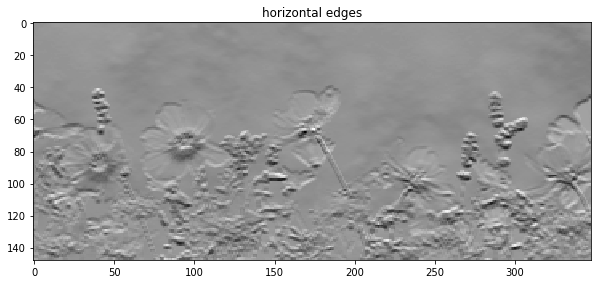

In [15]:
plt.figure(figsize=(10,10))
plt.title("horizontal edges")
plt.imshow(out[0,:,:,0], cmap="gray")

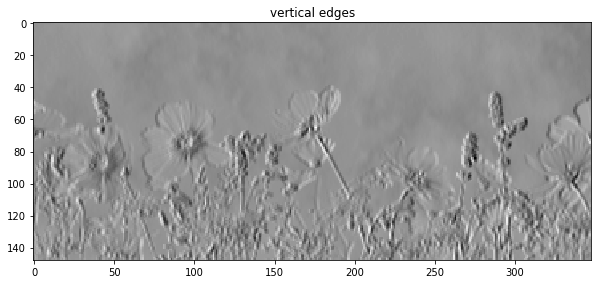

In [14]:
plt.figure(figsize=(10,10))
plt.title("vertical edges")
plt.imshow(out[0,:,:,1], cmap="gray")